libs import

In [35]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, Imputer, StandardScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import zconfint
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

EDA

In [2]:
df = pd.read_csv(r'F:\Work\My\Python\examples\titanic_example\titanic3.csv', decimal=',')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [4]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
df.describe(include=['O'])

,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,929,186,3,27,369
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


In [6]:
df.isnull().sum()/len(df)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

Visualization

In [7]:
target_column = 'survived'
num_columns = list(df.select_dtypes(include=['float', 'int64']).columns.values)
cat_columns = list(df.select_dtypes(include=['O']).columns.values)

num_columns.remove(target_column)
num_columns += [target_column]
cat_columns += [target_column]

num_df = df[num_columns]
cat_df = df[cat_columns]

print(num_df.isnull().sum())
print('')
print(cat_df.isnull().sum())

pclass         0
age          263
sibsp          0
parch          0
fare           1
body        1188
survived       0
dtype: int64

name            0
sex             0
ticket          0
cabin        1014
embarked        2
boat          823
home.dest     564
survived        0
dtype: int64


numeric features

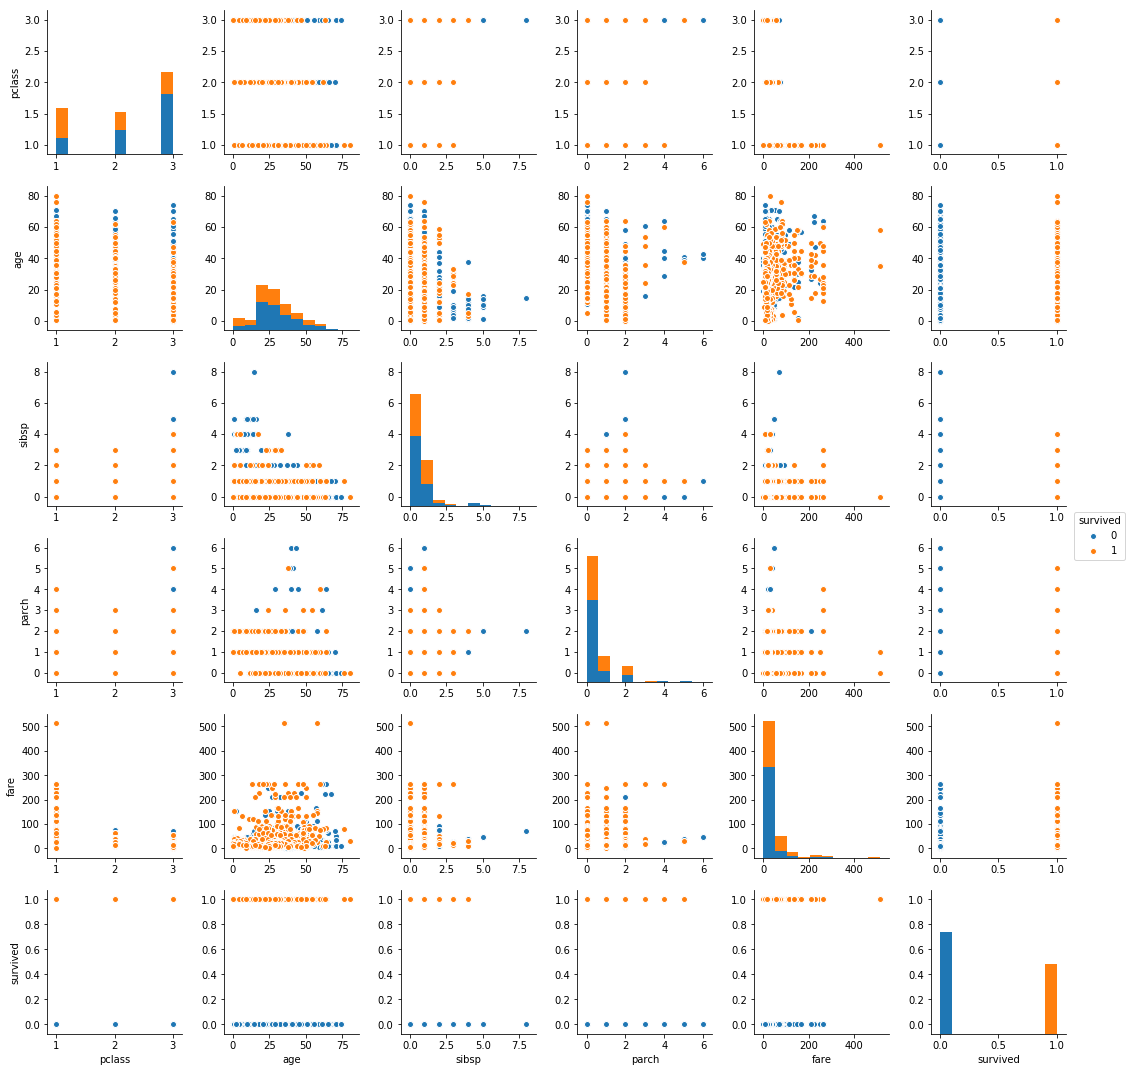

In [8]:
visual_num_df = num_df.drop(['body'], axis=1).dropna()
sns.pairplot(visual_num_df, hue=target_column)

plt.show()

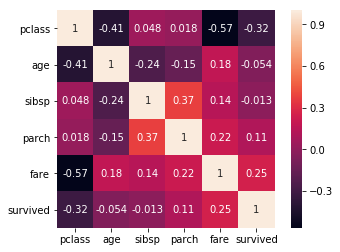

In [9]:
num_corrs = visual_num_df.corr()
sns.heatmap(num_corrs, square=True, annot=True)

plt.show()

categorical features

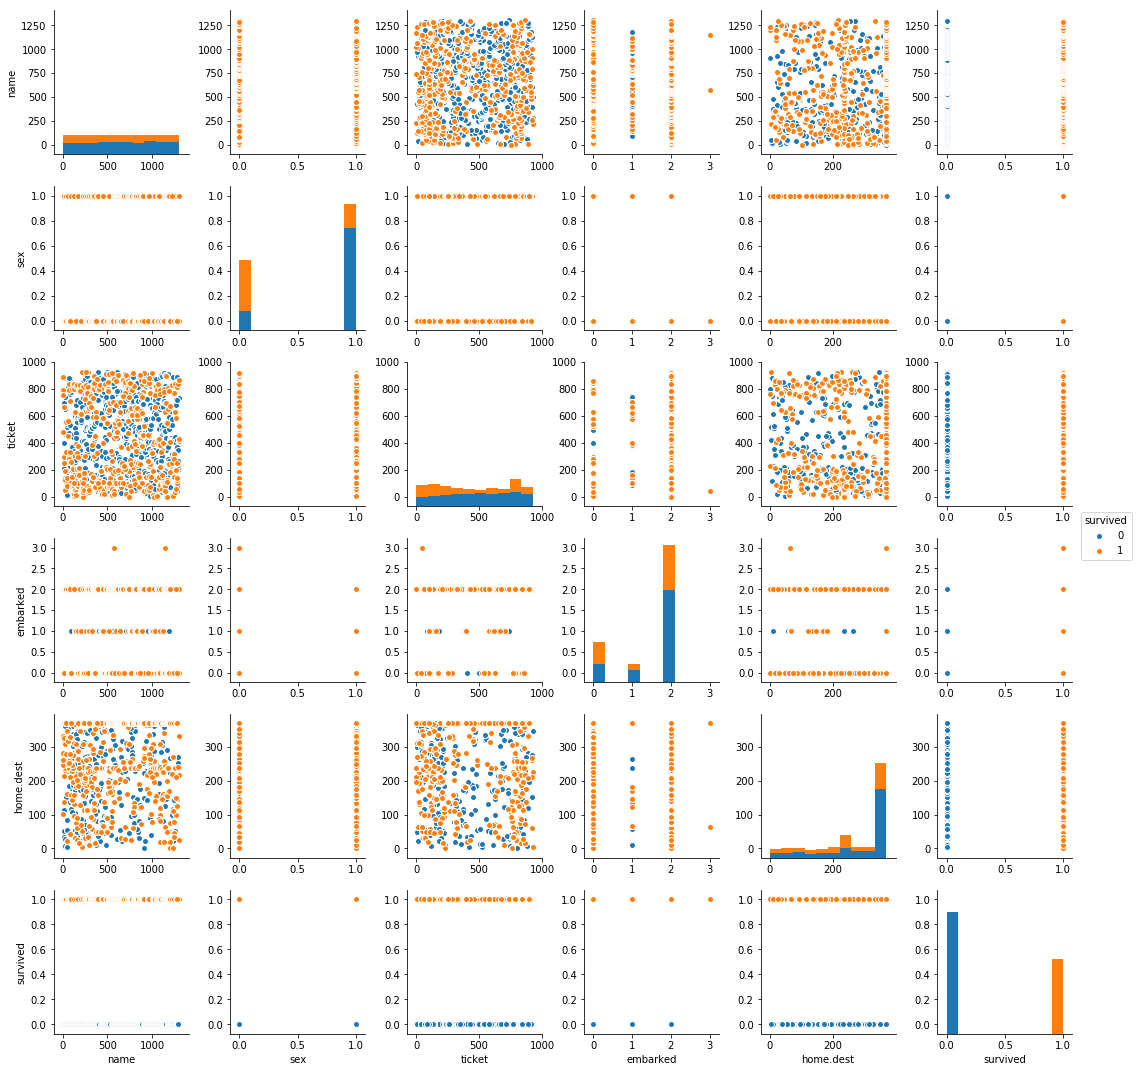

In [10]:
visual_cat_df = cat_df.drop(['cabin', 'boat'], axis=1).fillna('__none__')

for column in visual_cat_df.columns:
    enc = LabelEncoder()
    visual_cat_df[column] = enc.fit_transform(visual_cat_df[column])
    
sns.pairplot(visual_cat_df, hue=target_column)
    
plt.show()

In [11]:
corr_df = visual_cat_df.drop([target_column], axis=1) \
                       .apply(lambda col: matthews_corrcoef(col.values, visual_cat_df[target_column]), axis=0)

corr_df

name         0.000000
sex         -0.528693
ticket      -0.001113
embarked    -0.081622
home.dest    0.001998
dtype: float64

Hypotheses testing

4.1 Women (Sex=female) were more likely to have survived

In [12]:
XW = df[df['sex'] == 'female'][target_column]
XM = df[df['sex'] == 'male'][target_column]

Proportions:

In [13]:
print('Survived woman mean:', XW.mean())
print('Survived man mean:', XM.mean())

Survived woman mean: 0.7274678111587983
Survived man mean: 0.19098457888493475


Confidence intervals:

In [14]:
woman_conf_int = proportion_confint(XW.sum(), len(XW))
man_conf_int = proportion_confint(XM.sum(), len(XM))

print('95%% conf int for woman:', woman_conf_int)
print('95%% conf int for man:', man_conf_int)

95%% conf int for woman: (0.68704086597867964, 0.76789475633891702)
95%% conf int for man: (0.16445002108828838, 0.21751913668158113)


Hypothesis H0: E(XW) = E(XM)

In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [16]:
def proportions_diff_z_test(sample1, sample2, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
    
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [17]:
res = proportions_diff_confint_ind(XW, XM)

print('95%% conf int for proportion diff:', res)

95%% conf int for proportion diff: (0.48812601301903158, 0.58484045152869546)


In [18]:
p_value = proportions_diff_z_test(XW, XM)

print('p_value', p_value)

p_value 0.0


4.2 Passengers with bigger fare were most likely to be survived

In [19]:
XS = df[df[target_column]==1]['fare'].dropna()
XD = df[df[target_column]==0]['fare'].dropna()

Means:

In [20]:
print('Survived fare mean:', XS.mean())
print('Survived fare mean:', XD.mean())

Survived fare mean: 49.36118360000002
Survived fare mean: 23.35383056930686


z-conf ints

In [21]:
print('95%% conf int for survived fare:', zconfint(XS))
print('95%% conf int for died fare:', zconfint(XD))

95%% conf int for survived fare: (43.343961953038949, 55.378405246961059)
95%% conf int for died fare: (20.99948208934228, 25.708179049271585)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


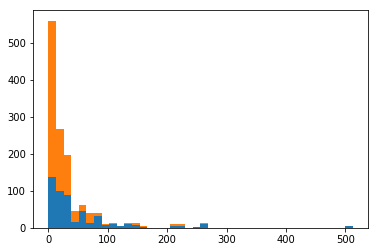

In [22]:
plt.hist([XS, XD], bins=40, histtype='bar', stacked=True)
plt.show()

The distributions are NON normal. Use Mann-Whitnew criteria

In [23]:
stats.mannwhitneyu(XS, XD)

MannwhitneyuResult(statistic=131452.5, pvalue=1.0885770643327487e-26)

Just a curiosity: Student's t-criteria

In [24]:
stats.ttest_ind(XS, XD)

Ttest_indResult(statistic=9.1031669418737664, pvalue=3.1936770125625333e-19)

Modeling

In [25]:
df = df.drop(['name'], axis=1)

num_columns.remove(target_column)
cat_columns.remove(target_column)
cat_columns.remove('name')

Filter outliers:

In [26]:
low  = 0.05
high = 0.95
quant_df = df[num_columns].quantile([low, high])
quant_df.head()

,pclass,age,sibsp,parch,fare,body
0.05,1.0,5.0,0.0,0.0,7.225,16.0
0.95,3.0,57.0,2.0,2.0,133.650,307.0


In [27]:
clean_df = df.copy()

for column in num_columns:
    ql = quant_df.loc[low, column]
    qh = quant_df.loc[high, column]
    clean_df = clean_df[clean_df[column].isnull() | ((ql <= clean_df[column]) & (clean_df[column] <= qh))]

In [28]:
clean_df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
5,1,1,male,48.0,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
8,1,1,female,53.0,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
12,1,1,female,24.0,0,0,PC 17477,69.3000,B35,C,9,NaN,"Paris, France"
13,1,1,female,26.0,0,0,19877,78.8500,NaN,S,6,NaN,NaN
15,1,0,male,NaN,0,0,PC 17318,25.9250,NaN,S,NaN,NaN,"New York, NY"


Split data

In [29]:
X = clean_df.drop([target_column], axis=1)
y = clean_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=9)

Construct pipeline

In [30]:
class DummyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dummy_columns_ = None
        
    def fit(self, X, y=None, **kwargs):
        self.dummy_columns_ = pd.get_dummies(X, sparse=True, dummy_na=True).columns.values
        return self
    
    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self, ['dummy_columns_'])
        
        dummy_df = pd.get_dummies(X, dummy_na=True)
        res_df = pd.DataFrame()
        
        for column in self.dummy_columns_:
            res_df[column] = dummy_df[column] if column in dummy_df.columns.values else np.zeros((len(X),), dtype=int)

        return res_df

In [31]:
def get_pipeline(model):
    
    pipeline = Pipeline(steps=[
        
        ('processing', FeatureUnion([
            
            ('numeric', Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data.loc[:, num_columns], validate=False)),
                ('imputing',  Imputer(strategy='mean')),
                ('scaling',   StandardScaler())
            ])),
            
            ('categorical', Pipeline(steps=[
                ('selecting', FunctionTransformer(lambda data: data.loc[:, cat_columns], validate=False)),
                ('encoding', DummyEncoder())
            ])),
        ])),
        
        ('model', model)
    ])
    
    return pipeline    

Fit the model

In [33]:
model = DecisionTreeClassifier(random_state=9)
pipeline = get_pipeline(model)

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=9)
params = { 'model__max_depth': [5, 10, 20] }
grid = GridSearchCV(pipeline, params, scoring='accuracy', cv=cv, verbose=10)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print(grid.best_score_)
print(grid.best_params_)

Fitting 7 folds for each of 3 candidates, totalling 21 fits
[CV] model__max_depth=5 ..............................................
[CV] ..... model__max_depth=5, score=0.9830508474576272, total=   1.4s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9576271186440678, total=   1.4s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9915254237288136, total=   1.4s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9830508474576272, total=   1.4s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9576271186440678, total=   1.4s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.0s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9658119658119658, total=   1.3s
[CV] model__max_depth=5 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.7s remaining:    0.0s


[CV] ..... model__max_depth=5, score=0.9487179487179487, total=   1.4s
[CV] model__max_depth=10 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   12.6s remaining:    0.0s


[CV] .... model__max_depth=10, score=0.9745762711864406, total=   1.3s
[CV] model__max_depth=10 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.4s remaining:    0.0s


[CV] .... model__max_depth=10, score=0.9576271186440678, total=   1.3s
[CV] model__max_depth=10 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.1s remaining:    0.0s


[CV] .... model__max_depth=10, score=0.9915254237288136, total=   1.4s
[CV] model__max_depth=10 .............................................
[CV] .... model__max_depth=10, score=0.9830508474576272, total=   1.3s
[CV] model__max_depth=10 .............................................
[CV] .... model__max_depth=10, score=0.9576271186440678, total=   1.3s
[CV] model__max_depth=10 .............................................
[CV] .... model__max_depth=10, score=0.9743589743589743, total=   1.3s
[CV] model__max_depth=10 .............................................
[CV] .... model__max_depth=10, score=0.9487179487179487, total=   1.3s
[CV] model__max_depth=20 .............................................
[CV] .... model__max_depth=20, score=0.9745762711864406, total=   1.3s
[CV] model__max_depth=20 .............................................
[CV] .... model__max_depth=20, score=0.9576271186440678, total=   1.4s
[CV] model__max_depth=20 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   37.2s finished


0.969660194175
{'model__max_depth': 5}


Final score on holdout set:

In [37]:
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
score

0.96618357487922701